## Assignment 1 part3
Using Sagemaker for Satellite image processing and Classification


## Installs and imports

In [ ]:
%%capture
%pip install geopandas
%pip install shapely
%pip install --find-links=https://girder.github.io/large_image_wheels --no-cache GDAL
%pip install rasterio
%pip install Werkzeug==2.3.7
%pip install leafmap localtileserver matplotlib==3.6.3 folium==0.13.0
%pip install jupyter-server-proxy
%pip install sat-search
# included this to get files from google drive
!pip install gdown


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import re
from subprocess import run

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import matplotlib
import matplotlib.pyplot as plt

import boto3
import rasterio as rio

from rasterio.features import bounds
from rasterio.plot import show
from pyproj import Transformer
from rasterio.transform import Affine
import random
from rasterio.windows import Window

import satsearch

proxy_path = f"studiolab/default/jupyter/proxy/{{port}}"
os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = proxy_path

import localtileserver
from localtileserver import get_folium_tile_layer, TileClient, examples
import leafmap.foliumap as leafmap

import gdown

import pystac
import json
from datetime import datetime, timezone
from shapely.geometry import Polygon, mapping
from sklearn.cluster import KMeans

Restart kernel to enable functionality in some of the imports (don't reinstall after restart, go straight to imports)

### Helper functions

In [ ]:
def base_map():
    m = leafmap.Map()
    m.add_basemap("SATELLITE")
    m.add_tile_layer(
        url='https://server.arcgisonline.com/ArcGIS/rest/services/' +\
                'World_Imagery/MapServer/tile/{z}/{y}/{x}',
        name="ESRI",
        attribution="ESRI"
    )
    return m

def poly_box(lon, lat, delta):
    c1 = [lon + delta, lat + delta]
    c2 = [lon + delta, lat - delta]
    c3 = [lon - delta, lat - delta]
    c4 = [lon - delta, lat + delta]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

def get_subset(geotiff_file, geometry):
    with rio.Env(aws_session):
        with rio.open(geotiff_file) as src:#geo_fp:

            # get bbox from bounds of GeoSeries
            poly = gpd.GeoSeries([Polygon(geometry["coordinates"][0])])\
                .set_crs(4326)\
                .to_crs(src.crs)
            bbox = bounds(poly)

            window = rio.windows.from_bounds(
                bbox[0], bbox[1], bbox[2], bbox[3], transform=src.transform
            )
            # Actual HTTP range request
            subset = src.read(1, window=window, boundless=True)
    return subset



## Get administrative areas

### Dataset Directory

In [ ]:
# setting the data directory
data_dir = f"{os.environ['HOME']}/Assignment"
if not os.path.isdir(data_dir):
    os.makedirs(data_dir, exist_ok=True)

### Read in shape

In [ ]:
# reading the malawi_tiles and aoi geojson file
malawi_file = os.path.join(data_dir, "malawi_tiles.geojson")
aoi_file = os.path.join(data_dir, "aoi.geojson")
tile = os.path.join(data_dir, "tile899698.tiff")
# Reading the GeoJSON file into a GeoDataFrame
malawi_tile = gpd.read_file(malawi_file)
aoi = gpd.read_file(aoi_file)

# display
malawi_tile.head()

,tile,tile_col,tile_row,geometry
0,841570,1009.0,938.0,"POLYGON ((32.90452 -9.41447, 32.96348 -9.41447..."
1,841571,1010.0,938.0,"POLYGON ((32.95452 -9.41447, 33.01347 -9.41447..."
2,841572,1011.0,938.0,"POLYGON ((33.00453 -9.41447, 33.06347 -9.41447..."
3,841590,1009.0,939.0,"POLYGON ((32.90452 -9.46448, 32.96348 -9.46448..."
4,841591,1010.0,939.0,"POLYGON ((32.95452 -9.46448, 33.01347 -9.46448..."


In [ ]:
aoi.head()

,geometry
0,"POLYGON ((33.28033 -13.73805, 33.28033 -13.629..."


In [ ]:
# finding tiles that are within the aoi. one will be used as geomerty for the spatial an temporal
# filtering
tilesinner = gpd.sjoin(malawi_tile, aoi, op='intersects', how='inner')
#print(tiles_within_aoi)


In [ ]:
m = base_map()
m.add_gdf(malawi_tile, style={"color": "white"}, layer_name="Malawi",
          zoom_to_layer=True)
m.add_gdf(aoi, style={"color": "red"}, layer_name="Area of Interest",
          zoom_to_layer=True)
m

### Filter for a specific area and time

#### Create ROI

In [ ]:
xy = malawi_tile[malawi_tile.tile==899698].geometry.centroid
geometry = poly_box(xy.x.iloc[0], xy.y.iloc[0], 0.01)
time_range = '2021-06-01/2021-06-30'
print(geometry)


{'type': 'Polygon', 'coordinates': [[[33.344, -13.675], [33.344, -13.695], [33.324000000000005, -13.695], [33.324000000000005, -13.675], [33.344, -13.675]]]}


### Get satellite data Spatio-temporal asset catalog (STAC) and the Query STAC catalog


In [ ]:
# Query STAC spatial and temporal filtering
s2_search = satsearch.Search.search(
    url = "https://earth-search.aws.element84.com/v0",
    #bbox=bbox,
    datetime=time_range,
    query={'eo:cloud_cover': {'lt': 10}},
    collections=['sentinel-s2-l2a-cogs'],
    intersects = geometry
)
s2_search

In [ ]:
# queried sentinel tiles
sentinel_items = s2_search.items()
print(sentinel_items.summary())

 # print out band 4 in the items(tiles)
for item in sentinel_items:
    red_s3 = item.assets['B04']['href']
    print(red_s3)

Items (7):
date                      id                        
2021-06-30                S2A_36LWK_20210630_0_L2A  
2021-06-27                S2A_36LWK_20210627_0_L2A  
2021-06-25                S2B_36LWK_20210625_0_L2A  
2021-06-20                S2A_36LWK_20210620_0_L2A  
2021-06-15                S2B_36LWK_20210615_0_L2A  
2021-06-12                S2B_36LWK_20210612_0_L2A  
2021-06-10                S2A_36LWK_20210610_0_L2A  

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/L/WK/2021/6/S2A_36LWK_20210630_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/L/WK/2021/6/S2A_36LWK_20210627_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/L/WK/2021/6/S2B_36LWK_20210625_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/L/WK/2021/6/S2A_36LWK_20210620_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/L/WK/2021/6/S2B_36L

### Find items or tiles with the least cloud cover <1%

In [ ]:
# Checking which of the sentinel items has the least cloud cover ( item 1 has theleast of 0

# make a list of all the items
item_list = [item for item in sentinel_items]

# Iterate through item_list and get the cloud cover property('eo:cloud_cover')
# the item with the least will be used later
cloud_cover_list = [item.properties['eo:cloud_cover'] for item in item_list]
print(cloud_cover_list)

# first item with the least cloud cover
item1 = item_list[0]
print(item1)
#print(item1.assets.keys())

# second item
item2 = item_list[2]
print(item2)

[0, 1.53, 0, 6.84, 0.42, 0.94, 1.33]
S2A_36LWK_20210630_0_L2A
S2B_36LWK_20210625_0_L2A


### Collect Bands 3, 4 and 8 of items 0 and 1

#### Set-up AWS session

In [ ]:
os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'
print("Creating AWS Session")
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)

Creating AWS Session


#### Convert geometry to GeoSeries

In [ ]:
with rio.open(red_s3) as src:
    src_meta = src.meta

geom_poly = gpd.GeoSeries(
    [Polygon(geometry["coordinates"][0])]
).set_crs(4326).to_crs(src_meta["crs"])
bbox = bounds(geom_poly)

Where is the ROI in relation to an S2 tile?

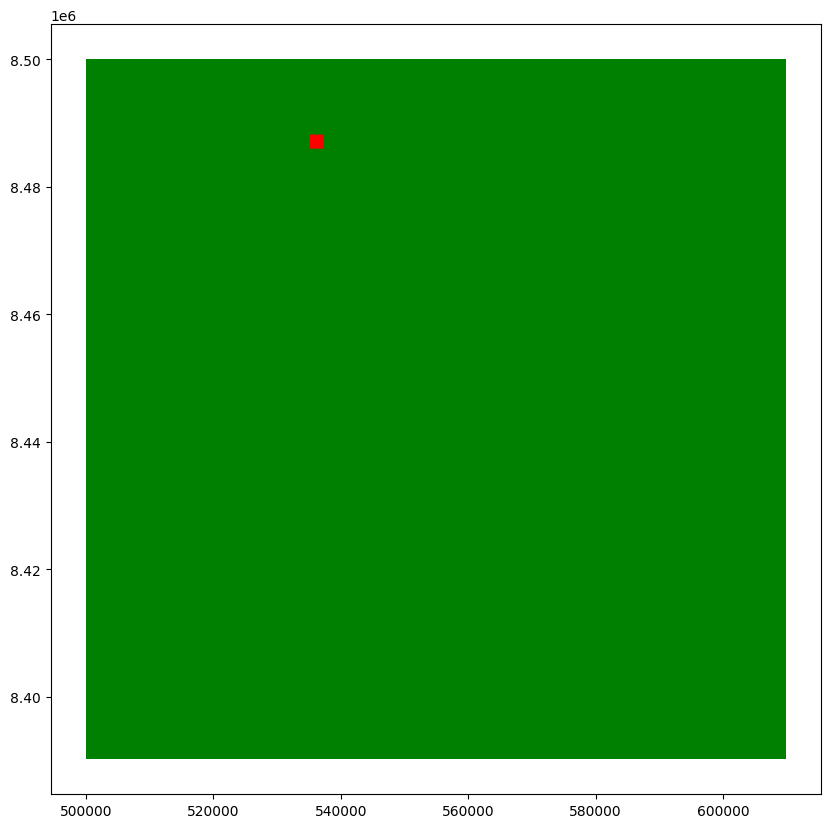

In [ ]:
src_extent = src.bounds
img_poly = gpd.GeoSeries(
    [box(src_extent.left, src_extent.bottom,
         src_extent.right, src_extent.top)]
)

fig, ax = plt.subplots(figsize=(10, 10))

img_poly.plot(color="green", ax=ax)
geom_poly.plot(color="red", ax=ax)
None

#### Read in subset from each band and date of the 1st tile with least cloud

In [ ]:
# items with list cloud
itemlist = [item1, item2]
print(itemlist)
print(item1.assets.keys())

[S2A_36LWK_20210630_0_L2A, S2B_36LWK_20210625_0_L2A]
dict_keys(['overview', 'thumbnail', 'metadata', 'B11', 'B01', 'B12', 'B02', 'B03', 'B04', 'AOT', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'WVP', 'visual', 'SCL', 'info'])


In [ ]:
# for the fisrt image
green_s3 = item1.assets['B03']['href']
red_s3 = item1.assets['B04']['href']
nir_s3 = item1.assets['B08']['href']

date = item.properties['datetime'][0:1]

print("Sentinel item number " + str(item1) + "/" + \
      str(len(itemlist)) + " " + date)
green = get_subset(green_s3, geometry)
red = get_subset(red_s3, geometry)
nir = get_subset(nir_s3, geometry)


Sentinel item number S2A_36LWK_20210630_0_L2A/2 2


### Combine the bands into an image

In [ ]:
# Combine the three bands into a single 3-band image
falseComposite = np.dstack((green, red, nir))
#print(falseComposite)

[[[ 820 1242 2176]
  [ 813 1238 2170]
  [ 802 1234 2156]
  ...
  [ 655  910 1626]
  [ 613  893 1654]
  [ 636  866 1784]]

 [[ 854 1308 2160]
  [ 834 1294 2156]
  [ 841 1278 2178]
  ...
  [ 663  923 1662]
  [ 647  913 1686]
  [ 636  860 1828]]

 [[ 831 1236 2154]
  [ 813 1228 2166]
  [ 831 1236 2200]
  ...
  [ 665  932 1684]
  [ 608  890 1716]
  [ 637  892 1832]]

 ...

 [[ 560  786 1680]
  [ 576  873 1816]
  [ 601  863 1766]
  ...
  [ 645  570 2570]
  [ 616  615 2510]
  [ 692  599 2598]]

 [[ 548  841 1390]
  [ 564  834 1744]
  [ 589  847 1824]
  ...
  [ 648  670 2382]
  [ 678  659 2504]
  [ 676  647 2552]]

 [[ 525  826 1360]
  [ 542  797 1606]
  [ 564  825 1858]
  ...
  [ 591  668 2328]
  [ 633  648 2426]
  [ 631  596 2596]]]


### Write to geotiff

#### Get and adjust metadata

In [ ]:
with rio.open(red_s3) as src:
    src_meta = src.meta

# src_meta
dst_meta = src_meta.copy()
dst_transform = list(src_meta["transform"])[0:6]
bbox = bounds(geom_poly)
dst_transform[2] = bbox[0]
dst_transform[5] = bbox[3]
dst_meta["dtype"] = np.float32
dst_meta["height"] = falseComposite.shape[0]
dst_meta["width"] = falseComposite.shape[1]
dst_meta["transform"] = Affine(*dst_transform)


#### To disk

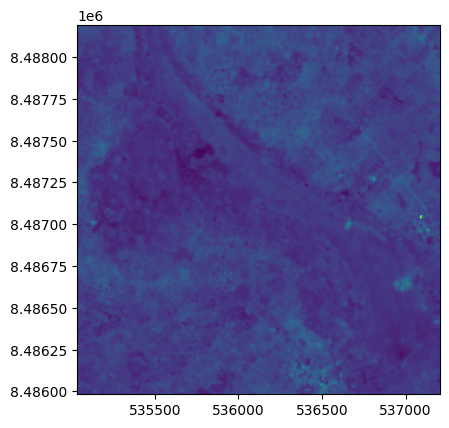

In [ ]:
# chatgpt
# Create a new GeoTIFF file
out_file = f"{data_dir}/falseComposite.tif"
# number of bands to be added to the file
bands = 3
dtype = falseComposite.dtype

# Update the metadata with the bands
dst_meta["count"] = bands
dst_meta["dtype"] = dtype

# Create a new file
with rio.open(out_file, 'w', **dst_meta) as dst:
    for band in range(bands):
        # Write each band to the new file
        dst.write(falseComposite[:, :, band], band + 1)

# Display the saved GeoTIFF
show(rio.open(out_file))
None





### 7-cluster KMens Model

In [ ]:
%%capture
%pip install rio-cogeo

Function to flatten the image because Kmeans needs the data values all in one row, with one column per band.

In [ ]:
with rio.open(out_file) as src:
    window = Window(179, 179, 2000, 2000)
    dst_transform = src.window_transform(window)
    dst_meta = src.meta.copy()

    falseComposite = src.read(window=window)


# get height and width of image
_, h, w = falseComposite.shape

In [ ]:
def get_flat(array):
    _, h, w = array.shape
    data = np.empty((h * w, len(array)))
    for i in range(len(array)):
        data[:, i] = array[i, :, :].flatten()

    return data


check the total piexls in the image and sample 10% of it

In [ ]:
data = get_flat(falseComposite).tolist()
#print(f"{len(data)} pixels in image")
random.seed(1) # this makes sure the same random sample is collected
data_sample = random.sample(data, 70)
#print(f"{len(data_sample)} pixels in sample")

### Fit the model and make a prediction using 7 clusters, or classes, identified.

In [ ]:
# fit the model with a random_state value, to ensure reproducibility
model = KMeans(n_clusters=7, random_state=1)
model.fit(data_sample)

KMeans(n_clusters=7, random_state=1)

Run the prediction, applying to the full reshaped image data

In [ ]:
#
# reshape the image
out = model.predict(data).reshape((h, w)).astype(np.uint8)

## write out the classified image

In [ ]:


out_file2 =  f"{data_dir}/classified.tif"
with rio.open(out_file2, "w+", **dst_meta) as dst:
    dst.write(out, 1)

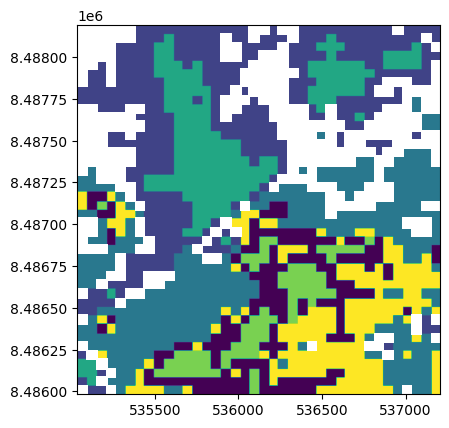

In [ ]:
# display the classification
show(rio.open(out_file2))
None

## plot the cluster image and Sentinel 3-band image (false color)

I run into trouble while reshaping it. I an error of size of the 651 not been able to resize to 43,38. I don't know if this is what is causing it not to display in hte right location.

In [ ]:
m = leafmap.Map()
m.add_basemap()
m.add_basemap("SATELLITE")
m.add_gdf(gpd.GeoDataFrame({"id": 1, "geometry": geom_poly}),
          style={"color": "blue"}, layer_name="Aear of Interest", zoom_to_layer=True)
m.add_raster(out_file, cmap="PRGn", layer_name="False Color Composite")
m.add_raster(str(out_file2), palette="Spectral", vmin=0, vmax=7,layer_name="Classified Image")
m